In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, RMS
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path
from tensorflow.keras.models import Model

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load in RMS data for tests

In [2]:
# exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
exps = ['Test 9']
rms = {}

for test in exps:
    rms[test] = resources.ae.RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass

--------------------------------------------------
Loaded RMS data for "22_11_30_weartest_1000"
Experiemnt No: Test 9
Number of files: 158
--------------------------------------------------


# Setup Variational Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [3]:
autoe = {}
for test in exps:
        """
        autoe[test] = VariationalAutoEncoder(rms[test],
                                           tb=False,
                                           tb_logdir=rms[test].exp_name,
                                           train_slice=(0, 50),
                                           random_state=1,
                                           params={'latent_dim': 2,
                                                   'n_size': [32, 16],
                                                   'epochs': 300,
                                                   'batch_size': 20,
                                                   'callbacks': [
                                                           tf.keras.callbacks.EarlyStopping(
                                                                monitor='val_loss',
                                                                patience=30,
                                                                mode='min',
                                                                start_from_epoch=100,
                                                           ),
                                                        ]
                                                   }
                                           )
        """
        autoe[test] = AutoEncoder(rms[test],
                                  tb=False,
                                  tb_logdir=rms[test].exp_name.upper().replace(' ', '_'),
                                  train_slice=(0, 65),
                                  val_frac=0.1,
                                  random_state=2,
                                  params={'n_bottleneck': 5,
                                          'n_size': [32,32],
                                          'epochs': 750,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=40,
                                                              mode='min',
                                                              start_from_epoch= 200,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )       

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 394)
	Input val shape: (7, 394)

AUTOE-Test_9-E-750-L-[32, 32, 5, 32, 32]-20230526-133040



In [4]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [5]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    if not os.path.exists(model_folder):
       os.makedirs(model_folder)
    assert os.path.exists(model_folder)

    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(f'{name}.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [6]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                      val_data=autoe[test].val_data,
                      verbose=0,
                      use_multiprocessing=True,
                      )

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [9]:
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    autoe[test].model.model_.load_weights(
        TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
    )
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

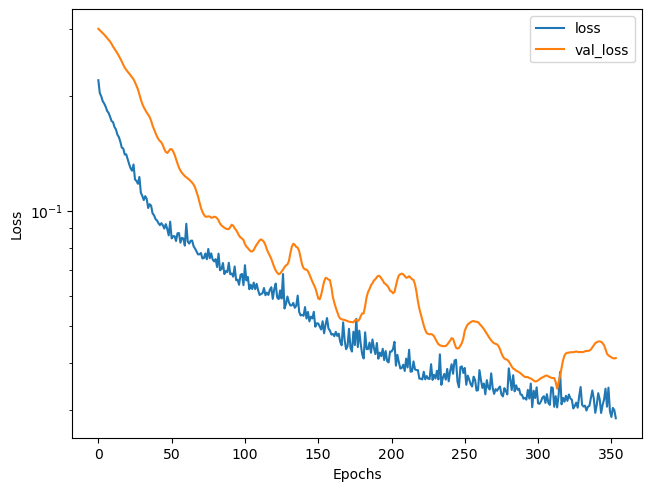

In [10]:
fig, ax = plt.subplots(1, len(exps),
                    #    figsize=(10,5),
                       constrained_layout=True,
                       )
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [11]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 9

Train Scores:
	MAE: 0.13255
	MSE: 0.03015
	R2: 0.18654

Val Scores:
	MAE: 0.14548
	MSE: 0.03420
	R2: 0.16505

Dataset Scores:
	MAE: 0.42221
	MSE: 0.51437
	R2: -1.40282


## Show histogram of scores across whole dataset

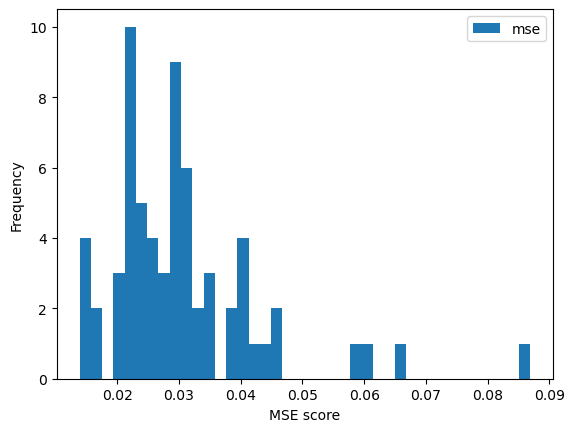

In [12]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

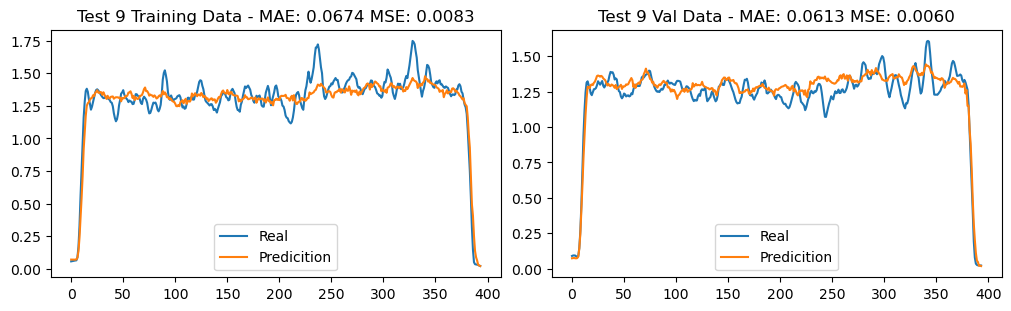

In [13]:
for test in exps:
    fig, ax = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'{autoe[test].RMS.exp_name} Training Data - {ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'{autoe[test].RMS.exp_name} Val Data - {ax[1].get_title()}')

## Thresholds for anomaly detection of each model

In [14]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.15785
	MSE cutoff: 0.04310
	R2 cutoff: -0.14734


## Show scores against threshold

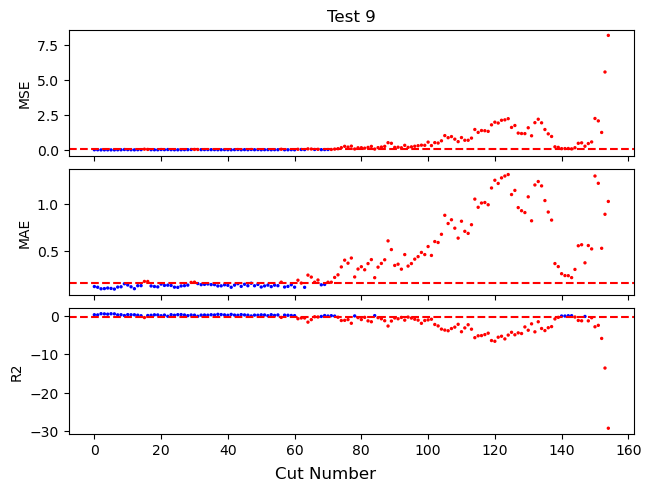

In [15]:
metrics = ['mse', 'mae', 'r2']

fig, ax = plt.subplots(len(metrics), len(exps),
                    #    figsize=(15, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [16]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 9
              mae         mse          r2
count  155.000000  155.000000  155.000000
mean     0.422211    0.514372   -1.402819
std      0.365764    0.964357    3.078754
min      0.094246    0.013878  -29.337758
25%      0.135855    0.030132   -2.184582
50%      0.242845    0.104605   -0.348917
75%      0.604180    0.590998    0.225447
max      1.314731    8.168369    0.609050


## autoe models latent space

In [17]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

/tmp/ipykernel_1381/4216758594.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


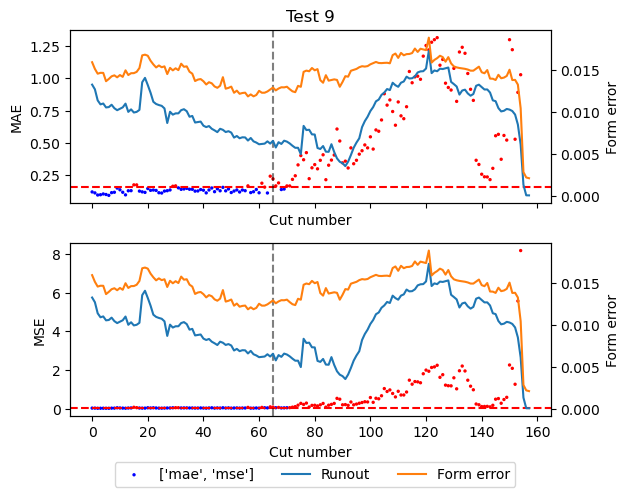

In [18]:
features = ['Runout', 'Form error']
metric = ['mae', 'mse']


fig, ax = plt.subplots(len(metric), len(exps),
                    #    figsize=(15, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )

ax2 = []
for a in ax.ravel():
    ax2.append(a.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature]
            axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)

        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel(f'{feature}')


for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              [metric] + lab2, 
              loc='center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

## Just Encoder

In [19]:

ae = autoe['Test 9'].model.model_
ae.summary()

print('\n')

encoder = Model(inputs=ae.get_layer('Encoder').input, outputs=ae.get_layer('Encoder').output)
encoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 394)]             0         
                                                                 
 Encoder (Functional)        (None, 5)                 14117     
                                                                 
 Decoder (Functional)        (None, 394)               14506     
                                                                 
Total params: 28,623
Trainable params: 28,367
Non-trainable params: 256
_________________________________________________________________


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 394)]             0         
                                                                 
 dense (Dense)               (No

In [20]:
input = rms['Test 9'].data.values
input = autoe['Test 9'].scaler.transform(input.T)

encoded = encoder.predict(input, verbose=0)
print(encoded.shape)

(155, 5)


In [21]:
exp = resources.load('Test 9')
target = exp.features['Runout']
target = target.drop([0, 1, 2], axis=0).values
inputs = np.concatenate([encoded, target.reshape(-1, 1)], axis=1)
main_df = pd.DataFrame(inputs, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'Target'])
main_df.head()

,L1,L2,L3,L4,L5,Target
0,0.0,0.0,0.968499,0.000000,2.118549,0.010906
1,0.0,0.0,0.880021,0.929785,2.246838,0.011009
2,0.0,0.0,1.314602,0.000000,2.543042,0.010544
3,0.0,0.0,1.104337,0.000000,2.641129,0.010585
4,0.0,0.0,0.740926,0.000000,2.549174,0.010863


In [22]:
ml = resources.LSTM_Model(feature_df=main_df,
                          target='Target',
                          tb=True,
                          tb_logdir='autoe_encoder_test',
                          params={'seq_len': 15,
                                  'epochs': 1000,
                                  'no_nodes': 128,
                                  'batch_size': 150,
                                  'no_layers': 3,
                                  'no_dense': 1,
                                  'dropout': 0.1,
                                  'loss': 'mse',
                                  'callbacks': [tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=75,
                                                              mode='min',
                                                              start_from_epoch= 200,
                                                  ),
                                  ]
                                  },
                          random_state=1,
)

Overlapping sections between exps not removed!


In [23]:
ml.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [24]:
ml._run_name

'/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard/LSTM/autoe_encoder_test/LSTM-WLEN-15-E-1000-B-150-L-[128 128 128 128]-D-0.1-20230526-133225'

In [25]:
ml.fit(validation_split=0.33, verbose=0)

-----------------------------------------------------------------
LSTM-WLEN-15-E-1000-B-150-L-[128 128 128 128]-D-0.1-20230526-133225


Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

In [26]:
ml.model.model_.load_weights(
    ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
)

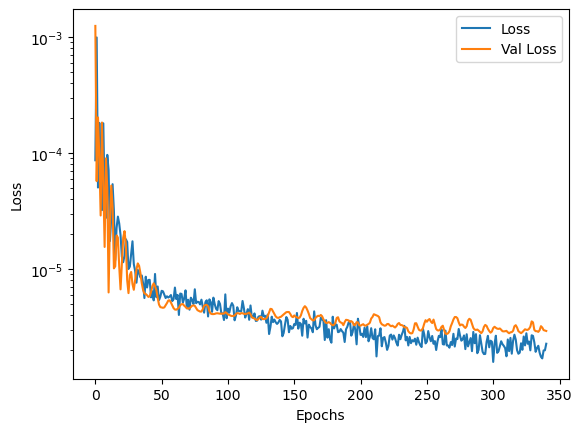

In [27]:
fig, ax = ml.loss_plot()
ax.set_yscale('log')

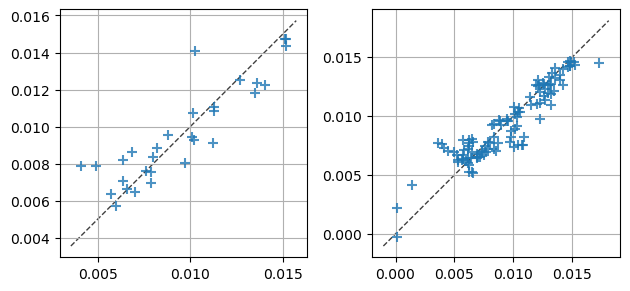

In [28]:
def pred_real_plot(y, y_pred, ax):
    ax.scatter(y, y_pred, marker='+', alpha=0.8, s=50)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.set_axisbelow(True)
    ax.grid()
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    ax.set_aspect('equal')
    return ax

fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml.val_data[1], ml.model.predict(ml.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml.train_data[1], ml.model.predict(ml.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [29]:
_ = ml.score(X=ml.train_data[0],
              y=ml.train_data[1],
              plot_fig=False,
              )
_ = ml.score(plot_fig=False)

-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.987 um
MSE = 1.763 um^2
R^2 = 0.859
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 1.081 um
MSE = 2.175 um^2
R^2 = 0.783
